In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import skimage
import matplotlib as mpl
from torch.fft import fft2, ifft2, fftshift
from copy import deepcopy
from tqdm.notebook import tqdm
import scipy
from wavefront import Wavefront
from probe import get_triangle_mask
import helper

In [3]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Setting up the probe

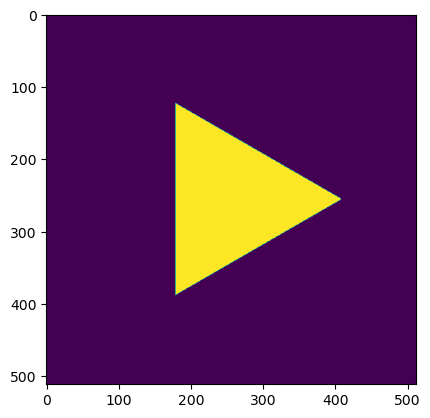

In [12]:
mask = get_triangle_mask()
plt.imshow(mask)
plt.show()

In [13]:
triangle = Wavefront(torch.tensor(mask.astype('float32'))).fftshift()

In [14]:
probe = triangle.prop_nearfield(1e-4, wavelength=0.25e-9,  pixel_size=[10e-6 / 512, 10e-6 / 512]).fftshift()

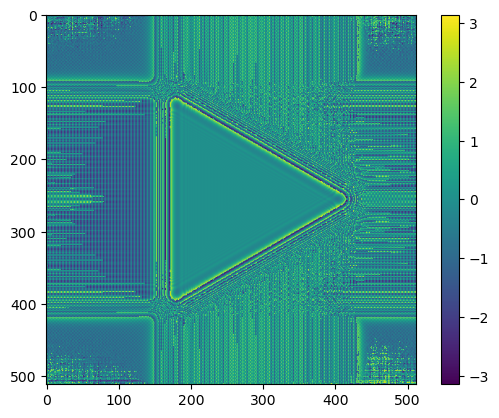

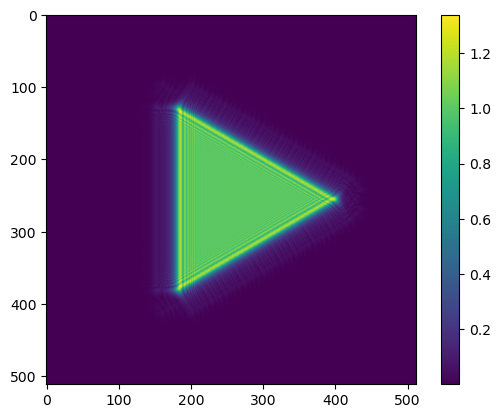

In [15]:
plt.imshow(probe.phase_numpy)
plt.colorbar()
plt.show()
plt.imshow(probe.amplitude_numpy)
plt.colorbar()
plt.show()

### Simulating phase object

In [16]:
obj_phase = skimage.data.camera() * np.pi / 255

In [17]:
obj_arr = np.exp(1j * obj_phase)

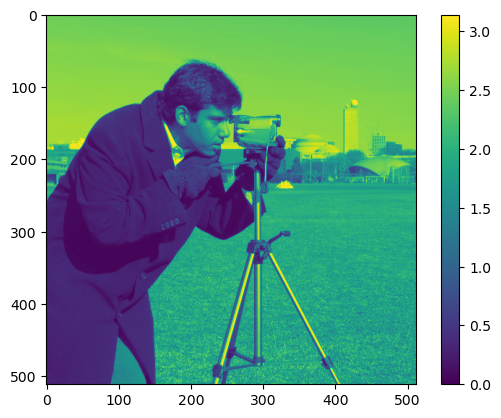

In [18]:
plt.imshow(np.angle(obj_arr))
plt.colorbar()

### Simulating true propagation

In [44]:
# Creating the probe by propagating the triangle to 1mm
# object/probe size at object plane is 10 um x 10 um
# Object/probe is 512 x 512 pix.
# wavelength is 5 kev

prop_dist = 1e-4 # 1 mm
pixel_size = [10e-6 / 512, 10e-6 / 512]
wavelength = 0.25e-9

### Phase retrieval with probe fixed. 

Since we know the true probe, we dont need to care about the propagation from the aperture to the object plane.

In [83]:
triangle = Wavefront(torch.tensor(mask.astype('complex64'))).fftshift()
probe_plane2_true = triangle.prop_nearfield(prop_dist, wavelength=0.25e-9,  pixel_size=pixel_size)

In [89]:
farfield_amps_true = helper.plane2_forward_model(obj_guess=obj_true, probe_plane2=probe_plane2_true).fftshift().amplitude

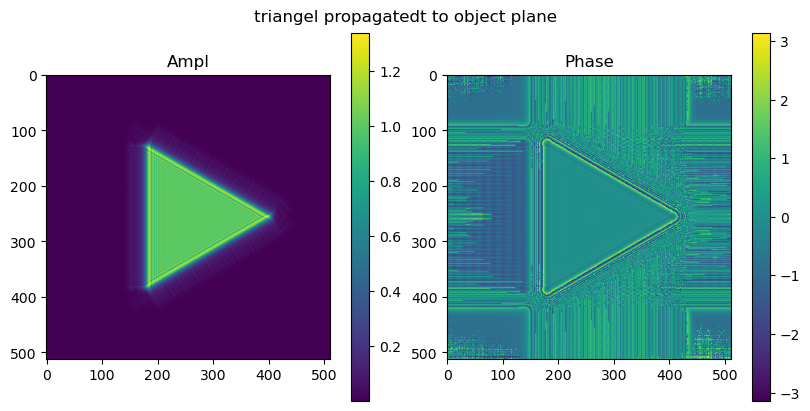

In [90]:
helper.plot2(probe_plane2_true, suptitle='triangel propagatedt to object plane')

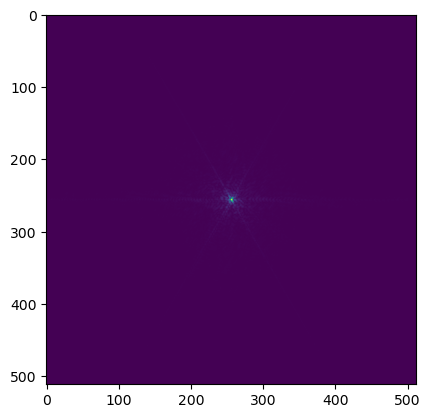

In [92]:
plt.imshow(farfield_amps_true.cpu())

###  Actual solution part

In [123]:
# plane1 is aperture plane, plane2 is object plane

probe_plane1 = Wavefront(torch.tensor(mask.astype('complex64'))).fftshift()
probe_plane2 = probe_plane1.prop_nearfield(prop_dist=prop_dist, wavelength=wavelength,  pixel_size=pixel_size)

obj_guess = torch.ones_like(obj_true, requires_grad=True)

In [124]:
optimizer = torch.optim.Adam(params=[obj_guess], lr=5e-4)

In [125]:
losses = []

In [126]:
N_EPOCHS = 5000

In [127]:
# actual optimization
for epoch in range(N_EPOCHS):
    optimizer.zero_grad()
    
    obj_constrained = helper.amplitude_constraint(obj_guess)
    #obj_constrained = obj_guess
    guess_amps = helper.plane2_forward_model(obj_constrained, probe_plane2).fftshift().amplitude
    loss = helper.loss_fn(guess_amps, farfield_amps_true)
    losses.append(loss.detach().cpu().numpy())
    loss.backward()
    optimizer.step()
    
    

In [128]:
obj_final = obj_guess.detach().cpu().numpy()

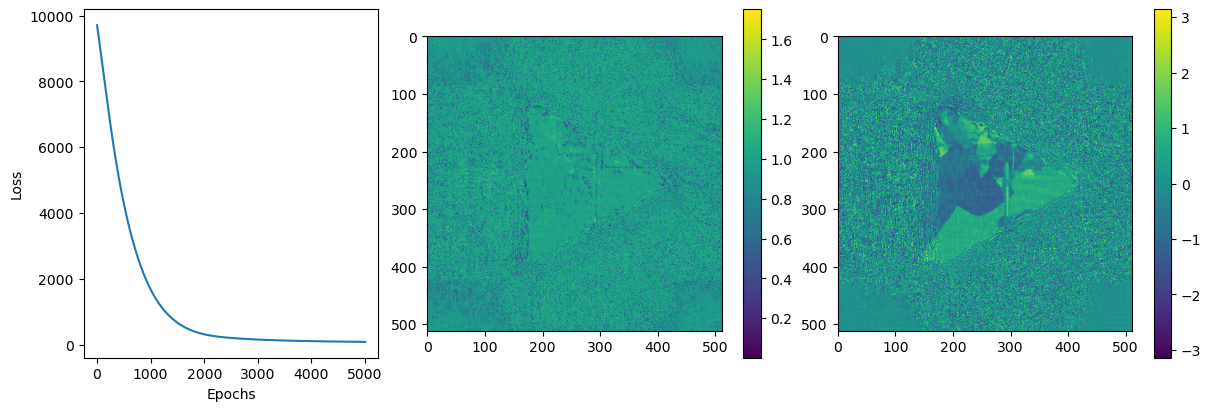

In [129]:
fig, axs = plt.subplots(1,3,figsize=[12,4], constrained_layout=True)
plt.subplot(1,3,1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.imshow(np.abs(obj_final))
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.angle(obj_final))
plt.colorbar()
